In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

# short audio clips

This notebook tries to deal with short audio clips.
Audio needs to be at least 3 seconds long to be processed by birdnet.
We can try to deal with this by padding the audio with a little bit of noise.

In [2]:
from birdclef.utils import get_spark
from pyspark.sql import functions as F

spark = get_spark()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/30 03:31:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
durations_df = spark.read.parquet(
    "gs://birdclef-2023/data/processed/birdclef-2023/train_durations_v2.parquet"
)
durations_df.show(n=5)

+--------------------+------------------+
|            filename|          duration|
+--------------------+------------------+
|abethr1/XC128013.ogg| 45.60979591836735|
|abethr1/XC363501.ogg|18.677596371882085|
|abethr1/XC363502.ogg| 38.76575963718821|
|abethr1/XC363503.ogg|29.257188208616782|
|abethr1/XC363504.ogg| 42.34453514739229|
+--------------------+------------------+
only showing top 5 rows



In [4]:
short_clips = durations_df.where("duration < 5").orderBy("duration")
short_clips.show(n=5)
short_clips.count()

+--------------------+------------------+
|            filename|          duration|
+--------------------+------------------+
| greegr/XC338469.ogg|0.5480272108843537|
|gobbun1/XC200993.ogg|0.5740136054421768|
| categr/XC368934.ogg|               0.6|
| litegr/XC147857.ogg| 0.626031746031746|
| categr/XC368933.ogg| 0.626031746031746|
+--------------------+------------------+
only showing top 5 rows



877

In [5]:
birdclef_root = "../data/raw/birdclef-2023"

In [6]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

first_track = short_clips.first().filename
y, sr = librosa.load(f"{birdclef_root}/train_audio/{first_track}", sr=48_000)
print(y.shape)

(26304,)


In [7]:
import IPython.display as ipd

ipd.Audio(f"{birdclef_root}/train_audio/{first_track}")

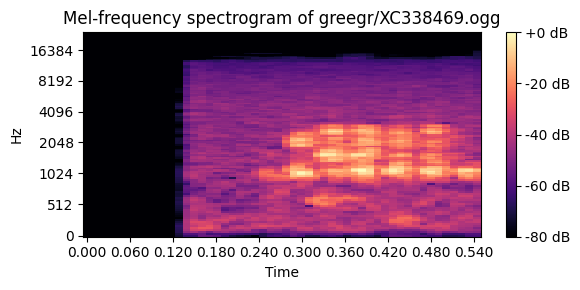

In [8]:
# generate a spectrogram and plot it
plt.figure(figsize=(6, 3))
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Mel-frequency spectrogram of {first_track}")
plt.tight_layout()
plt.show()

In [15]:
# lets add some noise to the signal and center it around that noise

print(f"max: {y.max():.2f}, min: {y.min():.2f}, mean: {y.mean():.2f}")

# lets generate noise using the same distribution as the signal. The shape
# should be rounded up the the nearest 3rd second.
noise_shape = (int(y.shape[0] / sr // 3) + 1) * 3 * sr
# lets multiply by 2 so we have at least 2 elements to work with
noise_shape *= 2
print(f"noise shape: {noise_shape}, seconds: {noise_shape / sr:.2f}")
noise = np.random.normal(loc=y.mean(), scale=y.std(), size=noise_shape)
print(f"max: {noise.max():.2f}, min: {noise.min():.2f}, mean: {noise.mean():.2f}")

# lets add the noise to the signal via weighted average, making the noise 10% of the signal
zero_pad_y = np.zeros(noise_shape)
# now place the signal in the center of the padding
start = (noise_shape - y.shape[0]) // 2
end = start + y.shape[0]
zero_pad_y[start:end] = y

y_noise = (zero_pad_y * 0.9) + (noise * 0.1)

# let's listen to this
ipd.Audio(y_noise, rate=sr)

max: 0.15, min: -0.12, mean: -0.00
noise shape: 288000, seconds: 6.00
max: 0.08, min: -0.09, mean: -0.00


In [16]:
from birdclef.data.utils import slice_seconds
from birdclef import birdnet

repo_path = "../vendor/BirdNET-Analyzer"
model = birdnet.load_model_from_repo(repo_path)
prediction_func = birdnet.prediction_func(model)

In [26]:
# load labels
labels = birdnet.load_labels(repo_path)
mapped_labels = birdnet.load_mapped_labels(repo_path)

X = slice_seconds(y_noise, sr, seconds=3, step=3)
pred = prediction_func(X)[0]
pred_sigmoid = 1 / (1 + np.exp(-pred))

indices = birdnet.rank_indices(pred_sigmoid)
print(indices)
[
    {
        "index": i,
        "label": labels[i],
        "mapped_label": mapped_labels[i],
        "probability": pred_sigmoid[0][i],
        "rank": rank,
    }
    for rank, i in enumerate(indices)
]

(2, 3337)
[2546 2812 1770 3216 1822 2232 2285 2480 2509 1543]


[{'index': 2546,
  'label': 'Psiloscops flammeolus_Flammulated Owl',
  'mapped_label': 'flaowl',
  'probability': 0.011626204,
  'rank': 0},
 {'index': 2812,
  'label': 'Siren_Siren',
  'mapped_label': 'siren1',
  'probability': 0.0059577553,
  'rank': 1},
 {'index': 1770,
  'label': 'Meleagris gallopavo_Wild Turkey',
  'mapped_label': 'wiltur',
  'probability': 0.0034415363,
  'rank': 2},
 {'index': 3216,
  'label': 'Tympanuchus phasianellus_Sharp-tailed Grouse',
  'mapped_label': 'shtgro',
  'probability': 0.0057953293,
  'rank': 3},
 {'index': 1822,
  'label': 'Mimus patagonicus_Patagonian Mockingbird',
  'mapped_label': 'patmoc1',
  'probability': 0.0003007958,
  'rank': 4},
 {'index': 2232,
  'label': 'Phaethon rubricauda_Red-tailed Tropicbird',
  'mapped_label': 'rettro',
  'probability': 0.00015630947,
  'rank': 5},
 {'index': 2285,
  'label': 'Phoebastria immutabilis_Laysan Albatross',
  'mapped_label': 'layalb',
  'probability': 0.0046322504,
  'rank': 6},
 {'index': 2480,
  '